### Начальные данные

In [136]:
import pandas as pd
import numpy as np

data = pd.Series(data={
    'a':0.0,
    'b':2.0,
    'k':2.0,
    'T':0.1,
    'h':0.1
})

data

a    0.0
b    2.0
k    2.0
T    0.1
h    0.1
dtype: float64

In [137]:
def u0(x): return 0
def m1(t): return 0
def m2(t): return 2*t
def f(x, t): return 1
def tau(h) : return np.round(np.divide(np.multiply(np.double(0.45), np.power(h, 2, dtype=np.double)), data['k']), 16)

### Явная схема Лаосонена

In [138]:
import numpy as np


def _laosonen(y_current: list, tn_current: float, h: float, tau_v: float) -> list:
    arr = [y_current[n] + tau_v * (data['k'] *
                                    (y_current[n+1] - 2 *
                                     y_current[n] + y_current[n - 1])
                                    / h ** 2 + f(data['a'] + h * n, tn_current))
           for n in np.arange(1, len(y_current)-1)]
    arr = np.append(m1(tn_current + tau_v), arr)
    return np.append(arr, m2(tn_current + tau_v))


def laosonen(h: float, tau_v: float) -> pd.DataFrame:
    h_values = np.linspace(data['a'], data['b'],
                           np.int32(np.round((data['b'] - data['a']) / h)))
    
    new_h = h_values[1] - h_values[0]
    
    l1 = [u0(i) for i in h_values[1:-1]]

    l1 = np.append(m1(0), l1)
    l1 = np.append(l1, m2(0))
    
    result = np.array(l1)

    tns = np.linspace(0, data['T'], np.int32(np.round(data['T'] / tau_v)))[1:]
    new_tau = tns[1] - tns[0]
    
    for tn in tns:
        l1 = _laosonen(l1, tn_current=tn, h=new_h, tau_v=new_tau)
        result = np.append(result, l1)

    result = pd.DataFrame(data=result.reshape(tns.shape[0]+1, -1), columns=h_values, index=np.append(0,tns))
    result.index.name = 't_n'
    result.columns.name = 'x_i'
    return result

### Отображение полученных слоев

In [139]:
import matplotlib.pyplot as plt

def print_contour(df: pd.DataFrame) -> None:
    plt.style.use('_mpl-gallery-nogrid')
    fig, ax = plt.subplots()
    X, Y = np.meshgrid(df.columns, df.index)
    Z = df.values

    contour = ax.contourf(X, Y, Z)
    cbar = fig.colorbar(contour)
    fig.set_figheight(4)
    fig.set_figwidth(6)
    ax.set_xlabel('$x_i$')
    ax.set_ylabel('$t_n$')
    fig.tight_layout()
    


### Неявная схема "Зонтик"

In [140]:
def TDMA(a, b, c, d, tn_next):
    _m1 = m1(tn_next)
    _m2 = m2(tn_next)

    n = len(d)

    alpha = np.zeros(n+1)
    beta = np.zeros(n+1)
    beta[0] = _m1
    res = np.zeros(n+1)
    res[-1] = _m2

    for i in np.arange(1, n+1):
        alpha[i] = b[i-1] / (c[i-1] - alpha[i-1] * a[i-1])

    for i in np.arange(1, n+1):
        beta[i] = (a[i-1]*beta[i-1] + d[i-1]) / (c[i-1] - alpha[i-1] * a[i-1])

    for i in np.arange(n-1, -1, -1):
        res[i] = alpha[i+1]*res[i+1] + beta[i+1]

    res = np.append(_m1, res)

    return res


In [141]:
def _umbrella(y_current: list, tn_current: float, h: float, tau_v:float) -> list:
    gamma = data['k'] * tau_v / h ** 2
    d = np.array([y_current[i] + tau_v * f(data['a'] + h * i, tn_current)
                       for i in np.arange(1, len(y_current) - 1)])
    
    a = np.repeat(gamma, len(d))
    c = np.repeat((1 + 2 * gamma), len(d))
    b = np.repeat(gamma, len(d))

    result = TDMA(a, b, c, d, tn_current+tau_v)

    return result


def umbrella(h: float, tau_v: float) -> pd.DataFrame:
    h_values = np.linspace(data['a'], data['b'],
                           np.int32(np.round((data['b'] - data['a']) / h)))
    
    new_h = h_values[1] - h_values[0]
    
    l1 = [u0(i) for i in h_values[1:-1]]
    
    l1 = np.append(m1(0), l1)
    l1 = np.append(l1, m2(0))
    
    result = np.array(l1)

    tns = np.linspace(0, data['T'], np.int32(np.round(data['T'] / tau_v)))[1:]
    new_tau = tns[1] - tns[0]
    
    for tn in tns:
        l1 = _umbrella(l1, tn_current=tn, h=new_h, tau_v=new_tau)
        result = np.append(result, l1)

    result = pd.DataFrame(data=result.reshape(tns.shape[0]+1, -1), columns=h_values, index=np.append(0, tns))
    result.index.name = 't_n'
    result.columns.name = 'x_i'
    return result


### Неявная схема Кранка-Николсона

In [142]:
def _krank_nikols(y_current: list, tn_current: float, h: float, tau_v:float) -> list:
    gamma = 0.5 * data['k'] * tau_v / h ** 2
    d = np.array([y_current[i] + gamma * \
                        (y_current[i+1] - 2*y_current[i] + y_current[i-1]) + \
                        tau_v * f(data['a'] + h * i, tn_current + 0.5 * tau_v)
                        for i in np.arange(1, len(y_current) -1)])
    
    a = np.repeat(gamma, len(d))
    c = np.repeat((1 + 2 * gamma), len(d))
    b = np.repeat(gamma, len(d))

    result = TDMA(a, b, c, d, tn_current + tau_v)

    return result


def krank_nikols(h: float, tau_v: float) -> pd.DataFrame:

    h_values = np.linspace(data['a'], data['b'],
                           np.int32(np.round((data['b'] - data['a']) / h)))
    
    new_h = h_values[1] - h_values[0]
    l1 = [u0(i) for i in h_values[1:-1]]
    
    l1 = np.append(m1(0), l1)
    l1 = np.append(l1, m2(0))
    
    result = np.array(l1)
    
    tns = np.linspace(0, data['T'], np.int32(np.round(data['T'] / tau_v)))[1:]
    new_tau = tns[1] - tns[0]
    
    for tn in tns:
        l1 = _krank_nikols(l1, tn_current=tn, h=new_h, tau_v=new_tau)
        result = np.append(result, l1)

    result = pd.DataFrame(data=result.reshape(tns.shape[0]+1, -1), columns=h_values, index=np.append(0, tns))
    result.index.name = 't_n'
    result.columns.name = 'x_i'
    return result

### Нахождение $h_{min}$

In [143]:
from typing import Callable


def get_inaccuracy(y_current: float, y_prev: float) -> float: return np.abs(
    (y_prev - y_current) / y_current)


def condition(inaccuracy: float, p: int) -> bool: return inaccuracy <= 10e-4 * \
    (np.power(2, p+1) - 2) / 2


def find_h(method: Callable[[float, float], pd.DataFrame], p: int) -> tuple:
    h = data['h']
    res = method(h, tau(h))

    mid_value = res.loc[data['T']].median()

    while(True):
        h /= 2
        res = method(h, tau(h))
        new_mid_value =  res.loc[data['T']].median()

        inaccuracy = get_inaccuracy(new_mid_value, mid_value)

        if(condition(inaccuracy, p)):
            mid_value = new_mid_value
            break

        mid_value = new_mid_value

    return (h, res)


In [144]:
def get_h_values(h_min) -> list: 
    return [data['h'] / np.power(2, i) for i in np.arange(round(np.log2(data['h'] / h_min))+1)]

def get_tau_values(h_min) -> list:
    return list(map(tau, get_h_values(h_min)))


### Нахождение погрешностей при фиксированых $h_{min}$ и $\tau_{min}$

In [145]:
def get_inaccuracy_for_tau(method: Callable[[float, float], pd.DataFrame], h_min) -> tuple:
    _tau = tau(h_min)
    _h_values = get_h_values(h_min)

    res = [method(_h_value, _tau).loc[data['T']].median()
               for _h_value in _h_values]
    results = [get_inaccuracy(res[i], res[i - 1])
               for i in range(1, len(res))]

    return (_h_values[1:], results)


def get_inaccuracy_for_h(method: Callable[[float, float], pd.DataFrame], h_min) -> tuple:
    _tau_values = get_tau_values(h_min)

    res = [method(h_min, _tau_value).loc[data['T']].median()
               for _tau_value in _tau_values]

    results = [get_inaccuracy(res[i], res[i - 1])
               for i in range(1, len(res))]

    return (_tau_values[1:], results)


In [189]:
def find_incrs_for_h_vals(method: Callable[[float, float], pd.DataFrame],
                          h_vals: list,
                          h_min: float):
    _tau = tau(h_min)

    res = [method(_h_value, _tau).loc[data['T']].median()
               for _h_value in h_vals]
    results = [get_inaccuracy(res[i], res[i - 1])
               for i in range(1, len(res))]

    return results

def find_incrs_for_tau_vals(method: Callable[[float, float], pd.DataFrame],
                          tau_vals: list,
                          h_min: float):

    res = [method(h_min, _tau_value).loc[data['T']].median()
               for _tau_value in tau_vals]
    results = [get_inaccuracy(res[i], res[i - 1])
               for i in range(1, len(res))]

    return results

### Поиск $h_{min}$ для метода Лаосонена

In [147]:
laosonen_h, res = find_h(laosonen, 1)
laosonen_h

0.025

### Отборжение значений ДУ на $t_i$ слоях

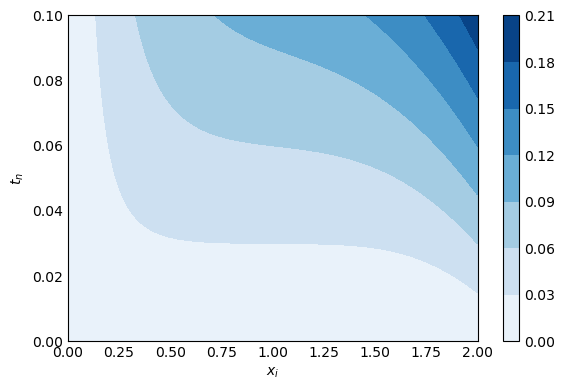

In [148]:
print_contour(res)

### Поиск $h_{min}$ для схемы "Зонтик"

In [149]:
umbrella_h, res2 = find_h(umbrella, 1)
umbrella_h

0.025

### Отборжение значений ДУ на $t_i$ слоях

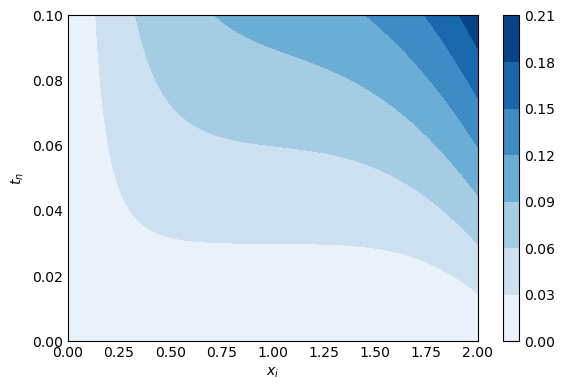

In [150]:
print_contour(res2)

### Поиск $h_{min}$ для схемы Кранка-Николсона

In [151]:
h_krank_nicols, res3 = find_h(krank_nikols, 2)
h_krank_nicols

0.025

### Отборжение значений ДУ на $t_i$ слоях

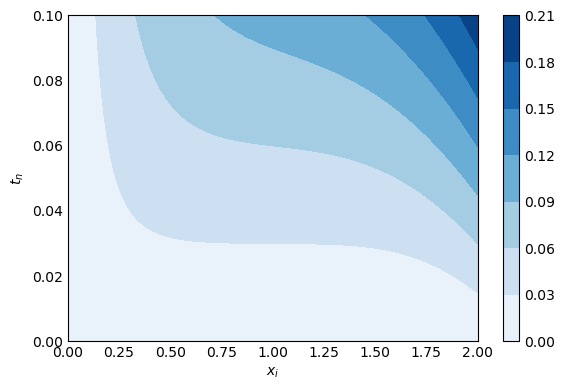

In [152]:
print_contour(res3)

### Для схемы Кранка-Николсона построим график погрешность в зависимости от шага $h$

In [164]:
h_vals, incrs_vals = get_inaccuracy_for_tau(krank_nikols, h_krank_nicols)
h_vals

[0.05, 0.025]

In [190]:
_h_values = [0.6, 0.3 , 0.15, 0.075, 0.032]

In [191]:
incrs_vals_for_h = find_incrs_for_h_vals(krank_nikols, _h_values , h_krank_nicols)
incrs_vals_for_h

[0.00012493165249579264,
 1.4261155207958412e-05,
 3.5568968270401212e-06,
 4.317923280508853e-07]

Text(0, 0.5, 'Ψh')

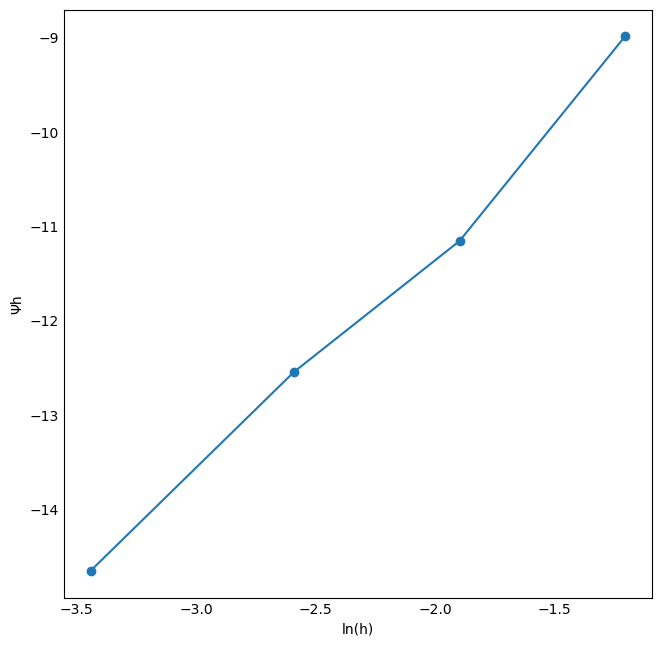

In [192]:
plt.figure(figsize=(6,6))
plt.plot(np.log(_h_values[1:]), np.log(incrs_vals_for_h), marker='o')
plt.xlabel('ln(h)')
plt.ylabel('Ψh')

### Практическая погрешность для $h$

In [194]:
np.polyfit(np.log(_h_values[1:]), np.log(incrs_vals_for_h), deg=1)

array([ 2.47950775, -6.1753433 ])

### Для схемы Кранка-Николсона построим график погрешность в зависимости от шага $\tau$

In [205]:
tau_vals = [0.025, 0.0125, 0.0062, 0.0031]
incrs_vals_for_tau = find_incrs_for_tau_vals(krank_nikols, tau_vals, h_krank_nicols)

In [206]:
incrs_vals_for_tau

[0.02295772997756906, 0.014126369495513586, 0.0071616775107656225]

Text(0, 0.5, 'Ψτ')

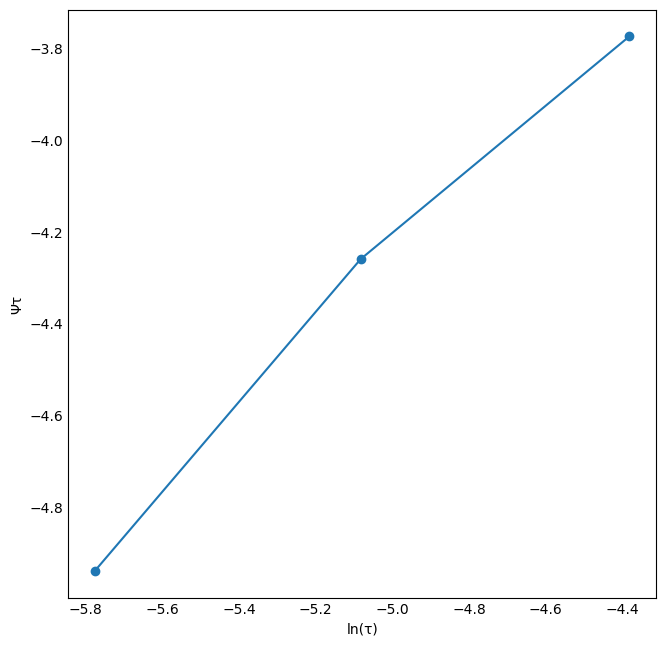

In [207]:
plt.figure(figsize=(6,6))
plt.plot(np.log(tau_vals[1:]), np.log(incrs_vals_for_tau), marker='o')
plt.xlabel('ln(τ)')
plt.ylabel('Ψτ')

### Практическая погрешность для $\tau$

In [208]:
np.polyfit(np.log(tau_vals[1:]), np.log(incrs_vals_for_tau), deg=1)

array([ 0.83518862, -0.08107488])